# Autoencoder Reconstruction Error for Anomaly Detection

## Autoencoder Architecture

An autoencoder is a neural network designed to learn efficient data representations through reconstruction. It consists of:

### Components:
1. **Encoder**: Compresses input data into a lower-dimensional latent representation
2. **Decoder**: Reconstructs the original input from the latent representation
3. **Latent Space**: The compressed representation capturing essential patterns

```
Input → [Encoder] → Latent Space → [Decoder] → Reconstructed Output
```

## Reconstruction Error Principle

The reconstruction error measures the difference between original input and autoencoder output. This error serves as an anomaly indicator.

### Mathematical Foundation:

**Reconstruction Error Formula:**
```
Error = ||x - x̂||²
```
Where:
- `x` = Original input
- `x̂` = Reconstructed output
- `||·||²` = Squared Euclidean norm (L2 norm)

### Anomaly Detection Mechanism:

1. **Normal Pattern Learning**: During training on normal data, the autoencoder learns to efficiently encode and decode typical patterns
2. **Compression Efficiency**: Normal patterns are represented in the latent space with low reconstruction error
3. **Anomaly Detection**: Anomalous patterns cannot be efficiently compressed using learned normal representations
4. **Error Threshold**: Higher reconstruction errors indicate deviations from learned normal patterns

## Detection Process

### 1. Training Phase (Normal Data Only):
```python
# Train autoencoder on normal patterns
for normal_sample in normal_data:
    latent = encoder(normal_sample)
    reconstructed = decoder(latent)
    loss = mse(normal_sample, reconstructed)
    # Minimize reconstruction error for normal patterns
```

### 2. Threshold Determination:
Calculate reconstruction errors on normal validation data and set threshold using:
- **Statistical method**: `threshold = μ + k×σ` (typically k=2 or 3)
- **Percentile-based**: 95th or 99th percentile of normal errors
- **ROC optimization**: Threshold that maximizes true positive rate

### 3. Detection Phase:
```python
# Detect anomalies in new data
reconstruction_error = ||x_new - autoencoder(x_new)||²
is_anomaly = reconstruction_error > threshold
```

## Statistical Foundation

### Normal Data Distribution:
- Reconstruction errors follow normal distribution for typical data
- Low mean error with small variance
- Predictable error patterns

### Anomaly Characteristics:
- Higher reconstruction errors due to poor fit with learned patterns
- Outlier behavior in error distribution
- Pattern deviation from training distribution

### Performance Metrics:
1. **True Positive Rate (Sensitivity)**: Correctly detected anomalies
2. **False Positive Rate**: Normal data incorrectly flagged as anomalous
3. **AUC-ROC**: Area under receiver operating characteristic curve
4. **Precision/Recall**: Trade-off between detection accuracy and false alarms

### Implementation Considerations:

1. **Unsupervised Learning**: Requires only normal operation data
2. **Real-time Detection**: Fast inference for continuous monitoring
3. **Adaptive Thresholds**: Can adjust to changing operational conditions
4. **Multivariate Analysis**: Considers relationships between multiple sensors
5. **Temporal Patterns**: LSTM autoencoders capture time-series dependencies

In [1]:
# Environment Setup and Module Imports
import time
import sys
import os

start_time = time.time()

print("Loading 3W Dataset for Autoencoder Novelty Detection")
print("=" * 60)

# Add src to path and import modules
sys.path.append("src")

print("Importing modules...", end=" ")
from src.data_persistence import DataPersistence
from src.unsupervised_preprocessing import UnsupervisedDataLoader
from src import config
import pandas as pd
import numpy as np

print("✅")

# Initialize components
print("Initializing data persistence...", end=" ")
persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
data_loader = UnsupervisedDataLoader(persistence, config)
print("✅")

print(f"Using data format: {config.SAVE_FORMAT}")

Loading 3W Dataset for Autoencoder Novelty Detection
Importing modules... ✅
Initializing data persistence... ✅
Using data format: pickle
✅
Initializing data persistence... ✅
Using data format: pickle


In [2]:
# Data Loading Configuration
USE_SINGLE_FOLD = (
    False  # True: Fast loading (one fold), False: Complete dataset (all folds)
)
TARGET_FOLD = "fold_1"  # Which fold to use for single fold loading
MAX_NORMAL_SAMPLES = 2000  # Limit normal samples for faster processing
MAX_ANOMALY_SAMPLES = 1000  # Limit anomaly samples for better class coverage
ENABLE_SAMPLING = True  # True: Apply sampling limits, False: Load all available data
SELECTED_ANOMALY_CLASSES = [3, 4, 8]  # Only use these classes as anomalies

print("Data Loading Configuration:")
print(f"   • Single fold loading: {USE_SINGLE_FOLD}")
if USE_SINGLE_FOLD:
    print(f"   • Target fold: {TARGET_FOLD}")
print(f"   • Sampling enabled: {ENABLE_SAMPLING}")
if ENABLE_SAMPLING:
    print(f"   • Max normal samples: {MAX_NORMAL_SAMPLES}")
    print(f"   • Max anomaly samples: {MAX_ANOMALY_SAMPLES}")
print(f"   • Selected anomaly classes: {SELECTED_ANOMALY_CLASSES}")

Data Loading Configuration:
   • Single fold loading: False
   • Sampling enabled: True
   • Max normal samples: 2000
   • Max anomaly samples: 1000
   • Selected anomaly classes: [3, 4, 8]


## 📊 Data Loading Strategy for Unsupervised Learning

### The Unsupervised Approach
Unlike supervised learning where we need both normal and anomalous examples during training, unsupervised anomaly detection follows a different strategy:

**Training Phase**: Use only **normal operation data**
- The autoencoder learns to reconstruct typical patterns
- No anomaly data is used during training

**Testing Phase**: Evaluate on both normal and anomalous data
- Normal data should have low reconstruction error
- Anomalous data should have high reconstruction error

### Configuration Parameters
- `USE_SINGLE_FOLD`: Controls dataset size (fast demo vs full dataset)
- `MAX_NORMAL_SAMPLES`: Limits normal data for training efficiency
- `SELECTED_ANOMALY_CLASSES`: Which anomaly types to detect

In [3]:
# Load Windowed Data for Unsupervised Learning
try:
    normal_windows, normal_classes, anomaly_windows, anomaly_classes, load_info = (
        data_loader.load_unsupervised_data(
            use_single_fold=USE_SINGLE_FOLD,
            target_fold=TARGET_FOLD,
            max_normal_samples=MAX_NORMAL_SAMPLES,
            max_anomaly_samples=MAX_ANOMALY_SAMPLES,
            selected_anomaly_classes=SELECTED_ANOMALY_CLASSES,
            enable_sampling=ENABLE_SAMPLING,
        )
    )

    data_ready = True
    total_time = time.time() - start_time

    print(f"\n✅ Data Loading Summary:")
    print(f"   • Normal windows: {len(normal_windows)} (for training)")
    print(f"   • Anomaly windows: {len(anomaly_windows)} (for testing)")
    print(f"   • Folds processed: {load_info['folds_processed']}")
    print(f"   • Total execution time: {total_time:.3f} seconds")

except Exception as e:
    print(f"\n❌ Error loading data: {str(e)}")
    print(f"\nTroubleshooting:")
    print(f"   1. Make sure 'Data Treatment.ipynb' ran completely")
    print(f"   2. Check if windowed data was saved successfully")
    print(f"   3. Verify the processed_data directory exists")

    # Initialize empty variables for error case
    normal_windows, normal_classes = [], []
    anomaly_windows, anomaly_classes = [], []
    data_ready = False

Loading 3W Dataset for Unsupervised Anomaly Detection
Using all 3 folds for better class coverage
Configuration:
   • Processing folds: ['fold_1', 'fold_2', 'fold_3']
   • Selected anomaly classes: [3, 4, 8]
   • Sampling enabled: True
   • Max normal samples: 2000
   • Max anomaly samples: 1000

Processing fold_1 (1/3)...
   Loading and merging train+test data...   train(65595)  train(65595)  test(10217)  -> Total: 75812 windows

Processing fold_2 (2/3)...
   Loading and merging train+test data...   test(10217)  -> Total: 75812 windows

Processing fold_2 (2/3)...
   Loading and merging train+test data...   train(66516)  train(66516)  test(9296)  -> Total: 75812 windows

Processing fold_3 (3/3)...
   Loading and merging train+test data...   test(9296)  -> Total: 75812 windows

Processing fold_3 (3/3)...
   Loading and merging train+test data...   train(65148)  train(65148)  test(10664)  -> Total: 75812 windows

✅ Data loading completed successfully!
   • Normal windows (class 0): 2000


In [ ]:
# Import Required Libraries for Autoencoder
print("LSTM Autoencoder for Anomaly Detection")
print("=" * 45)

# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Import custom modules
from src.autoencoder_models import StableLSTMAutoencoder
from src.unsupervised_preprocessing import UnsupervisedDataPreprocessor
from src.anomaly_detection import AnomalyDetector

# Set TensorFlow configuration
tf.config.run_functions_eagerly(False)

# Validate data availability
if data_ready and len(normal_windows) > 0 and len(anomaly_windows) > 0:
    print("✅ Data available for processing")
    print(f"   • Normal windows: {len(normal_windows)}")
    print(f"   • Anomaly windows: {len(anomaly_windows)}")
else:
    print("❌ No data available. Please run the previous cells first.")
    data_ready = False

LSTM Autoencoder for Anomaly Detection
✅ Data available for processing
   • Normal windows: 2000
   • Anomaly windows: 999


## 🧠 LSTM Autoencoder Architecture

### Why LSTM Autoencoders for Time Series?

**LSTM (Long Short-Term Memory)** networks are perfect for time series data because they:
- Remember long-term dependencies in sensor readings
- Capture temporal patterns in oil well operations
- Handle variable-length sequences effectively

### Autoencoder Components:
1. **LSTM Encoder**: Compresses time series into fixed-size latent vector
2. **Latent Space**: Compact representation of input patterns
3. **LSTM Decoder**: Reconstructs original time series from latent vector

### The Learning Process:
```
Normal Data → [LSTM Encoder] → Latent Vector → [LSTM Decoder] → Reconstructed Data
                                      ↓
                               Minimize reconstruction error
```

During training, the model learns to efficiently represent normal operation patterns.

This implementation uses a modular approach with reusable components in the `src/` directory:

### Modules:

1. **`autoencoder_models.py`** - Contains the `StableLSTMAutoencoder` class with:
   - Stable architecture with gradient clipping
   - Conservative hyperparameters for numerical stability
   - Built-in training and prediction methods

2. **`unsupervised_preprocessing.py`** - Contains the `UnsupervisedDataPreprocessor` class with:
   - Data sampling for training efficiency
   - Data validation and conversion
   - Numerical stability enhancements

3. **`anomaly_detection.py`** - Contains the `AnomalyDetector` class with:
   - Reconstruction error computation
   - Threshold determination methods
   - Performance evaluation and visualization

## ⚙️ Data Preprocessing for this notebook

**Sampling**: Controls dataset size for practical training
- Balances training time with performance
- Ensures representative data coverage

**Validation**: Checks data quality and consistency
- Removes corrupted or invalid samples
- Ensures proper tensor shapes for neural networks

In [5]:
# ============================================================
# DATA PREPROCESSING AND SAMPLING
# ============================================================

if data_ready:
    print("Data Preprocessing Pipeline")
    print("=" * 35)

    # Initialize data preprocessor with conservative settings for stability
    preprocessor = UnsupervisedDataPreprocessor(
        max_training_samples=1000,  # Reduced for stability
        max_anomaly_samples=300,  # Reduced for stability
        random_seed=42,
    )

    # Run the complete preprocessing pipeline with anomaly class information
    normal_scaled, anomaly_scaled, data_info, processed_anomaly_classes = (
        preprocessor.prepare_full_pipeline(
            normal_windows, anomaly_windows, anomaly_classes
        )
    )

    print(f"\n  Data preprocessing completed successfully!")
    print(f"Final Configuration:")
    print(f"   • Time steps per window: {data_info['time_steps']}")
    print(
        f"   • Features per time step: {data_info['n_features']} (class column removed)"
    )
    print(f"   • Normal training samples: {data_info['n_normal_samples']}")
    print(f"   • Anomaly test samples: {data_info['n_anomaly_samples']}")

    # Show final anomaly class distribution after preprocessing
    if processed_anomaly_classes is not None:
        from collections import Counter

        final_class_dist = Counter(str(cls) for cls in processed_anomaly_classes)
        print(f"   • Final anomaly class distribution: {dict(final_class_dist)}")

        # Update global anomaly_classes to match processed data
        anomaly_classes = processed_anomaly_classes
    else:
        print(f"   • No anomaly class information available")

    preprocessing_complete = True

else:
    print("  Cannot proceed with preprocessing - no data available")
    preprocessing_complete = False

Data Preprocessing Pipeline
🔧 Complete Data Preparation Pipeline
⚡ Smart Data Sampling for Training Efficiency
🎯 Training optimization settings:
   • Max normal samples for training: 1000
   • Max anomaly samples for testing: 300
📊 Sampling 1000 normal windows from 2000 available...
📊 Balanced sampling 300 anomaly windows from 999 available...
   • Target samples per class: 100
   • Class 3: 100 samples selected from 333 available
   • Class 4: 100 samples selected from 333 available
   • Class 8: 100 samples selected from 333 available

✅ Sampling complete:
   • Normal windows: 1000
   • Anomaly windows: 300
   • Anomaly class distribution: {'3': 100, '4': 100, '8': 100}
📊 Converting normal windows to arrays... ✅ (1000 valid processed)
📊 Converting anomaly windows to arrays... ✅ (300 valid processed)
🔍 Validating array shapes and data quality...
Expected shape: (300, 3)
✅ Valid arrays: 1000 normal, 300 anomaly
📊 Data quality checks:
   • Normal data range: [0.000, 1.000]
   • Anomaly 

## 🏗️ Building and Training the Autoencoder

### Model Architecture Parameters

**Latent Dimension**: The "bottleneck" size that forces compression
- Smaller = more compression, may lose important details
- Larger = retains more information, less compression

**LSTM Units**: The "memory capacity" of each LSTM layer
- More units = can learn more complex patterns
- Fewer units = simpler model, faster training

### Training Strategy for Anomaly Detection

**Key Principle**: Train ONLY on normal data
- Model learns to reconstruct typical operational patterns
- Anomalies will have higher reconstruction errors because they weren't seen during training

**No Validation Split**: We use ALL normal data for training
- Maximizes the model's exposure to normal patterns
- Validation would be performed separately on mixed normal/anomaly data

In [6]:
# ============================================================
# BUILD AND TRAIN LSTM AUTOENCODER
# ============================================================

if preprocessing_complete:
    print("Building and Training LSTM Autoencoder")
    print("=" * 45)

    # Initialize the autoencoder with conservative parameters for stability
    autoencoder = StableLSTMAutoencoder(
        time_steps=data_info["time_steps"],
        n_features=data_info["n_features"],
        latent_dim=64,  # Conservative for stability
        lstm_units=128,  # Conservative for stability
    )

    # Build the model
    model = autoencoder.build_model()

    # MODIFIED: Use ALL normal data for training (no train/validation split)
    # In unsupervised novelty detection:
    # - ALL normal data is used for training the autoencoder
    # - ALL anomaly data is used for testing/evaluation
    print(f"\nTraining Data Configuration:")
    print(f"   • Training samples: {len(normal_scaled)} (ALL normal data)")
    print(f"   • No validation split - using ALL normal data for training")
    print(f"   • Anomaly data will be used purely for testing")

    # Use all normal data for training
    train_normal = normal_scaled

    print(f"\nUnsupervised Learning Strategy:")
    print(f"   • Train autoencoder ONLY on normal operation patterns")
    print(f"   • Learn to reconstruct normal behavior with low error")
    print(f"   • High reconstruction error indicates anomalous patterns")

    # Train the autoencoder
    print(f"\nStarting Training...")
    training_start = time.time()

    # MODIFIED: No validation data since we use all normal data for training
    # The autoencoder will learn to reconstruct normal patterns only
    training_success = autoencoder.train(
        train_data=train_normal,
        val_data=None,  # No validation split - use all normal data for training
        epochs=30,  # Conservative for stability
        batch_size=32,  # Conservative for stability
        verbose=1,
    )

    training_time = time.time() - training_start
    print(f"\nTraining completed in {training_time:.2f} seconds")

    if training_success:
        print("  Model trained successfully on normal operation data")
        print("  Ready to detect anomalies based on reconstruction error")
        model_ready = True
    else:
        print("  Training failed - check for numerical stability issues")
        model_ready = False

else:
    print("  Cannot build model - preprocessing not completed")
    model_ready = False

Building and Training LSTM Autoencoder
🏗️ Building Stable LSTM Autoencoder:
   • Input shape: (300, 3)
   • Encoder LSTM units: 128
   • Latent dimension: 64
   • Decoder LSTM units: 128


✅ Stable LSTM Autoencoder model created
   • Total parameters: 175,043
   • Gradient clipping enabled (clipnorm=1.0)
   • Conservative learning rate (0.0005)

Training Data Configuration:
   • Training samples: 1000 (ALL normal data)
   • No validation split - using ALL normal data for training
   • Anomaly data will be used purely for testing

Unsupervised Learning Strategy:
   • Train autoencoder ONLY on normal operation patterns
   • Learn to reconstruct normal behavior with low error
   • High reconstruction error indicates anomalous patterns

Starting Training...
🚂 Training LSTM Autoencoder:
   • Training samples: 1000
   • No validation data - using all data for training
   • Max epochs: 30
   • Batch size: 32
✅ Stable LSTM Autoencoder model created
   • Total parameters: 175,043
   • Gradient 

## 📈 Training Progress Analysis

### Understanding the Learning Curves

**Loss Curve**: Shows how well the model learns to reconstruct normal data
- Decreasing loss = model getting better at reconstruction
- Stable loss = model has converged

**Mean Absolute Error (MAE)**: Alternative error metric
- More interpretable than MSE
- Less sensitive to outliers

### What to Look For:
- **Smooth decrease**: Good, stable learning
- **Oscillations**: May indicate learning rate too high
- **Plateau**: Model has reached its capacity or converged

  Training History Visualization


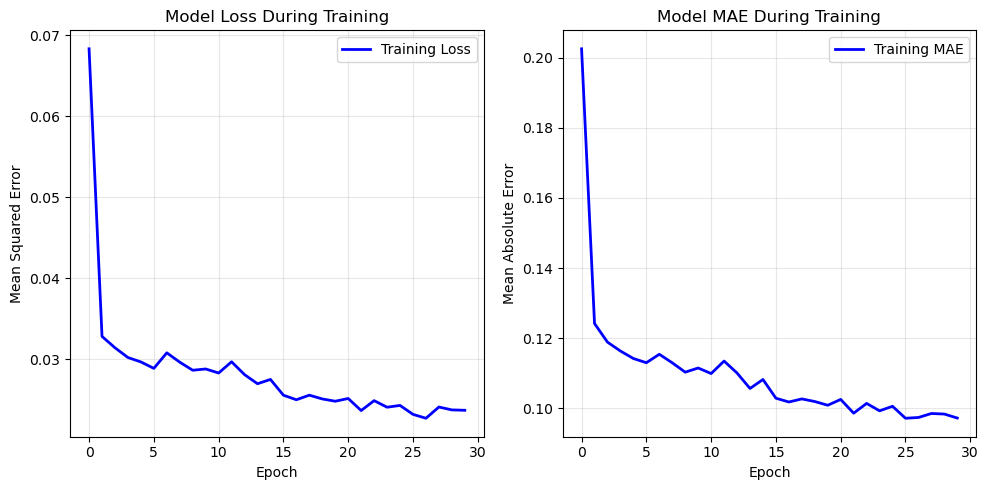


  Training Summary:
   • Epochs trained: 30
   • Final training loss: 0.023693
   • Training time: 305.00 seconds
   • No validation data used - trained on ALL normal data
   • Model learned to reconstruct normal operation patterns
   • Ready for anomaly detection based on reconstruction error


In [7]:
# ============================================================
# TRAINING VISUALIZATION
# ============================================================

if model_ready and autoencoder.history is not None:
    print("  Training History Visualization")
    print("=" * 35)

    history = autoencoder.history.history

    # Determine if we have validation data
    has_validation = "val_loss" in history

    # Create training plots - adjust based on available data
    if has_validation:
        plt.figure(figsize=(15, 5))
        subplot_count = 3
    else:
        plt.figure(figsize=(10, 5))
        subplot_count = 2

    # Loss plot
    plt.subplot(1, subplot_count, 1)
    plt.plot(history["loss"], label="Training Loss", linewidth=2, color="blue")
    if has_validation:
        plt.plot(
            history["val_loss"], label="Validation Loss", linewidth=2, color="orange"
        )
    plt.title("Model Loss During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # MAE plot
    plt.subplot(1, subplot_count, 2)
    plt.plot(history["mae"], label="Training MAE", linewidth=2, color="blue")
    if has_validation:
        plt.plot(
            history["val_mae"], label="Validation MAE", linewidth=2, color="orange"
        )
    plt.title("Model MAE During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Learning rate plot (if available) - only show if we have validation data
    if has_validation:
        plt.subplot(1, 3, 3)
        if "lr" in history:
            plt.plot(history["lr"], label="Learning Rate", linewidth=2, color="green")
            plt.title("Learning Rate Schedule")
            plt.xlabel("Epoch")
            plt.ylabel("Learning Rate")
            plt.yscale("log")
        else:
            plt.text(
                0.5,
                0.5,
                "Learning Rate\nHistory\nNot Available",
                ha="center",
                va="center",
                transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round", facecolor="lightgray"),
            )
            plt.title("Learning Rate Schedule")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print training summary
    final_train_loss = history["loss"][-1]
    epochs_trained = len(history["loss"])

    print(f"\n  Training Summary:")
    print(f"   • Epochs trained: {epochs_trained}")
    print(f"   • Final training loss: {final_train_loss:.6f}")
    print(f"   • Training time: {training_time:.2f} seconds")

    if has_validation:
        final_val_loss = history["val_loss"][-1]
        print(f"   • Final validation loss: {final_val_loss:.6f}")

        if final_val_loss < final_train_loss * 1.5:
            print("     No significant overfitting detected")
        else:
            print("    Possible overfitting - validation loss higher than expected")
    else:
        print("   • No validation data used - trained on ALL normal data")
        print("   • Model learned to reconstruct normal operation patterns")
        print("   • Ready for anomaly detection based on reconstruction error")

else:
    print("  No training history available for visualization")

## 🎯 Anomaly Detection and Threshold Setting

### The Detection Process

1. **Compute Reconstruction Errors**: For both normal and anomaly data
   - Normal data: Should have low errors (model was trained on this)
   - Anomaly data: Should have high errors (model hasn't seen these patterns)

2. **Determine Threshold**: The decision boundary
   - **Statistical Method**: μ + k×σ (mean + k standard deviations)
   - **Percentile Method**: 95th percentile of normal errors
   - Trade-off between false positives and true positives

3. **Evaluate Performance**: Compare predictions with known labels
   - **Normal Accuracy**: % of normal data correctly identified
   - **Anomaly Accuracy**: % of anomalies correctly detected

In [8]:
# Anomaly Detection and Threshold Determination
if model_ready:
    print("🔍 Anomaly Detection and Threshold Determination")
    print("=" * 45)

    # Initialize anomaly detector
    detector = AnomalyDetector()

    # Compute reconstruction errors
    normal_errors, anomaly_errors = detector.compute_reconstruction_errors(
        autoencoder=autoencoder, normal_data=normal_scaled, anomaly_data=anomaly_scaled
    )

    # Determine threshold using 95th percentile of normal errors
    threshold = detector.determine_threshold(method="percentile", percentile=95)

    # Evaluate detection performance
    metrics = detector.evaluate_detection()

    print(f"\n🎯 Overall Detection Results:")
    print(f"   • Threshold: {threshold:.6f}")
    print(f"   • Normal accuracy: {metrics.get('normal_accuracy', 'N/A')}")
    print(f"   • Anomaly accuracy: {metrics.get('anomaly_accuracy', 'N/A')}")
    print(f"   • Overall accuracy: {metrics.get('overall_accuracy', 'N/A')}")

    detection_complete = True

else:
    print("❌ Cannot perform anomaly detection - model not ready")
    detection_complete = False

🔍 Anomaly Detection and Threshold Determination
📊 Computing Reconstruction Errors
🔵 Computing reconstruction errors for normal data...
🔴 Computing reconstruction errors for anomaly data...
🔴 Computing reconstruction errors for anomaly data...
✅ Reconstruction errors computed:
   • Normal errors: 1000 samples
   • Anomaly errors: 300 samples
   • Normal error range: [0.000228, 0.107983]
   • Anomaly error range: [0.007337, 0.368851]
🎯 Determining Anomaly Threshold (percentile)
📈 Threshold set at 95th percentile: 0.050286
📊 Evaluating Anomaly Detection Performance
🎯 Detection Results:
   • Threshold: 0.050286
   • Normal data accuracy: 0.950 (950/1000)
   • Anomaly data accuracy: 0.730 (219/300)
   • Overall accuracy: 0.899
   • False positives (normal as anomaly): 50
   • False negatives (anomaly as normal): 81

🎯 Overall Detection Results:
   • Threshold: 0.050286
   • Normal accuracy: 0.95
   • Anomaly accuracy: 0.73
   • Overall accuracy: 0.8992307692307693
✅ Reconstruction errors co

## 📊 Per-Class Performance Analysis

### Why Analyze by Anomaly Class?

Different types of oil well problems have different characteristics:
- **Class 3**: Spurious DHSV closure
- **Class 4**: Flow instability  
- **Class 8**: Hydrate formation

### Performance Metrics:
- **Detection Accuracy**: How well each anomaly type is detected
- **Mean Error**: Average reconstruction error for each class
- **Class Distribution**: Number of samples per anomaly type

### Expected Results:
Some anomaly types may be easier to detect than others, depending on how different their patterns are from normal operation.

In [9]:
# Per-Class Detection Analysis
if detection_complete:
    print("📊 Per-Class Detection Performance Analysis")
    print("=" * 50)

    # Validate data alignment
    if len(anomaly_errors) != len(anomaly_classes):
        print(f"⚠️ Length mismatch between errors and classes - adjusting...")
        min_length = min(len(anomaly_errors), len(anomaly_classes))
        anomaly_errors = anomaly_errors[:min_length]
        anomaly_classes = anomaly_classes[:min_length]

    # Group errors by anomaly class
    from collections import defaultdict

    anomaly_class_errors = defaultdict(list)

    for error, cls in zip(anomaly_errors, anomaly_classes):
        cls_str = str(int(cls)) if isinstance(cls, (np.integer, int)) else str(cls)
        anomaly_class_errors[cls_str].append(float(error))

    # Calculate per-class metrics
    per_class_metrics = {}
    anomaly_class_colors = {}
    colors = ["red", "orange", "brown", "pink", "purple", "olive", "cyan"]

    print(f"\n{'Class':<8} {'Count':<8} {'Mean Error':<12} {'Accuracy':<10}")
    print("-" * 50)

    for i, (cls, errors) in enumerate(sorted(anomaly_class_errors.items())):
        errors_array = np.array(errors)
        mean_error = np.mean(errors_array)
        std_error = np.std(errors_array)

        # Calculate detection accuracy for this class
        detected = np.sum(errors_array > threshold)
        accuracy = detected / len(errors_array)

        color = colors[i % len(colors)]
        anomaly_class_colors[cls] = color

        per_class_metrics[cls] = {
            "count": len(errors_array),
            "mean_error": mean_error,
            "std_error": std_error,
            "accuracy": accuracy,
            "color": color,
        }

        print(f"{cls:<8} {len(errors_array):<8} {mean_error:<12.6f} {accuracy:<10.3f}")

    # Performance summary
    if per_class_metrics:
        best_class = max(per_class_metrics.items(), key=lambda x: x[1]["accuracy"])
        worst_class = min(per_class_metrics.items(), key=lambda x: x[1]["accuracy"])

        print(f"\n📈 Performance Summary:")
        print(
            f"   • Best detected: Class {best_class[0]} ({best_class[1]['accuracy']:.3f})"
        )
        print(
            f"   • Worst detected: Class {worst_class[0]} ({worst_class[1]['accuracy']:.3f})"
        )

        # Check for missing expected classes
        expected_classes = set(str(cls) for cls in SELECTED_ANOMALY_CLASSES)
        found_classes = set(per_class_metrics.keys())
        missing_classes = expected_classes - found_classes

        if missing_classes:
            print(f"   ⚠️ Missing classes: {sorted(missing_classes)}")
        else:
            print(f"   ✅ All expected classes analyzed")

        # Store for visualization
        globals()["per_class_metrics"] = per_class_metrics
        globals()["anomaly_class_colors"] = anomaly_class_colors

else:
    print("❌ Cannot perform per-class analysis - detection not completed")

📊 Per-Class Detection Performance Analysis

Class    Count    Mean Error   Accuracy  
--------------------------------------------------
3        100      0.185728     0.910     
4        100      0.047886     0.280     
8        100      0.210245     1.000     

📈 Performance Summary:
   • Best detected: Class 8 (1.000)
   • Worst detected: Class 4 (0.280)
   ✅ All expected classes analyzed


## 📈 Comprehensive Results Visualization

### Understanding the Visualizations

**Error Distribution Plot**: Shows the separation between normal and anomaly errors
- Good separation = easier anomaly detection
- Overlap = some ambiguous cases

**Per-Class Accuracy**: Bar chart showing detection performance for each anomaly type
- Helps identify which problems are easier/harder to detect

**ROC Analysis**: Receiver Operating Characteristic
- **AUC > 0.8**: Excellent performance
- **AUC > 0.7**: Good performance
- **AUC < 0.7**: May need model tuning

📈 Comprehensive Results Visualization
📈 Creating Comprehensive Per-Class Visualization


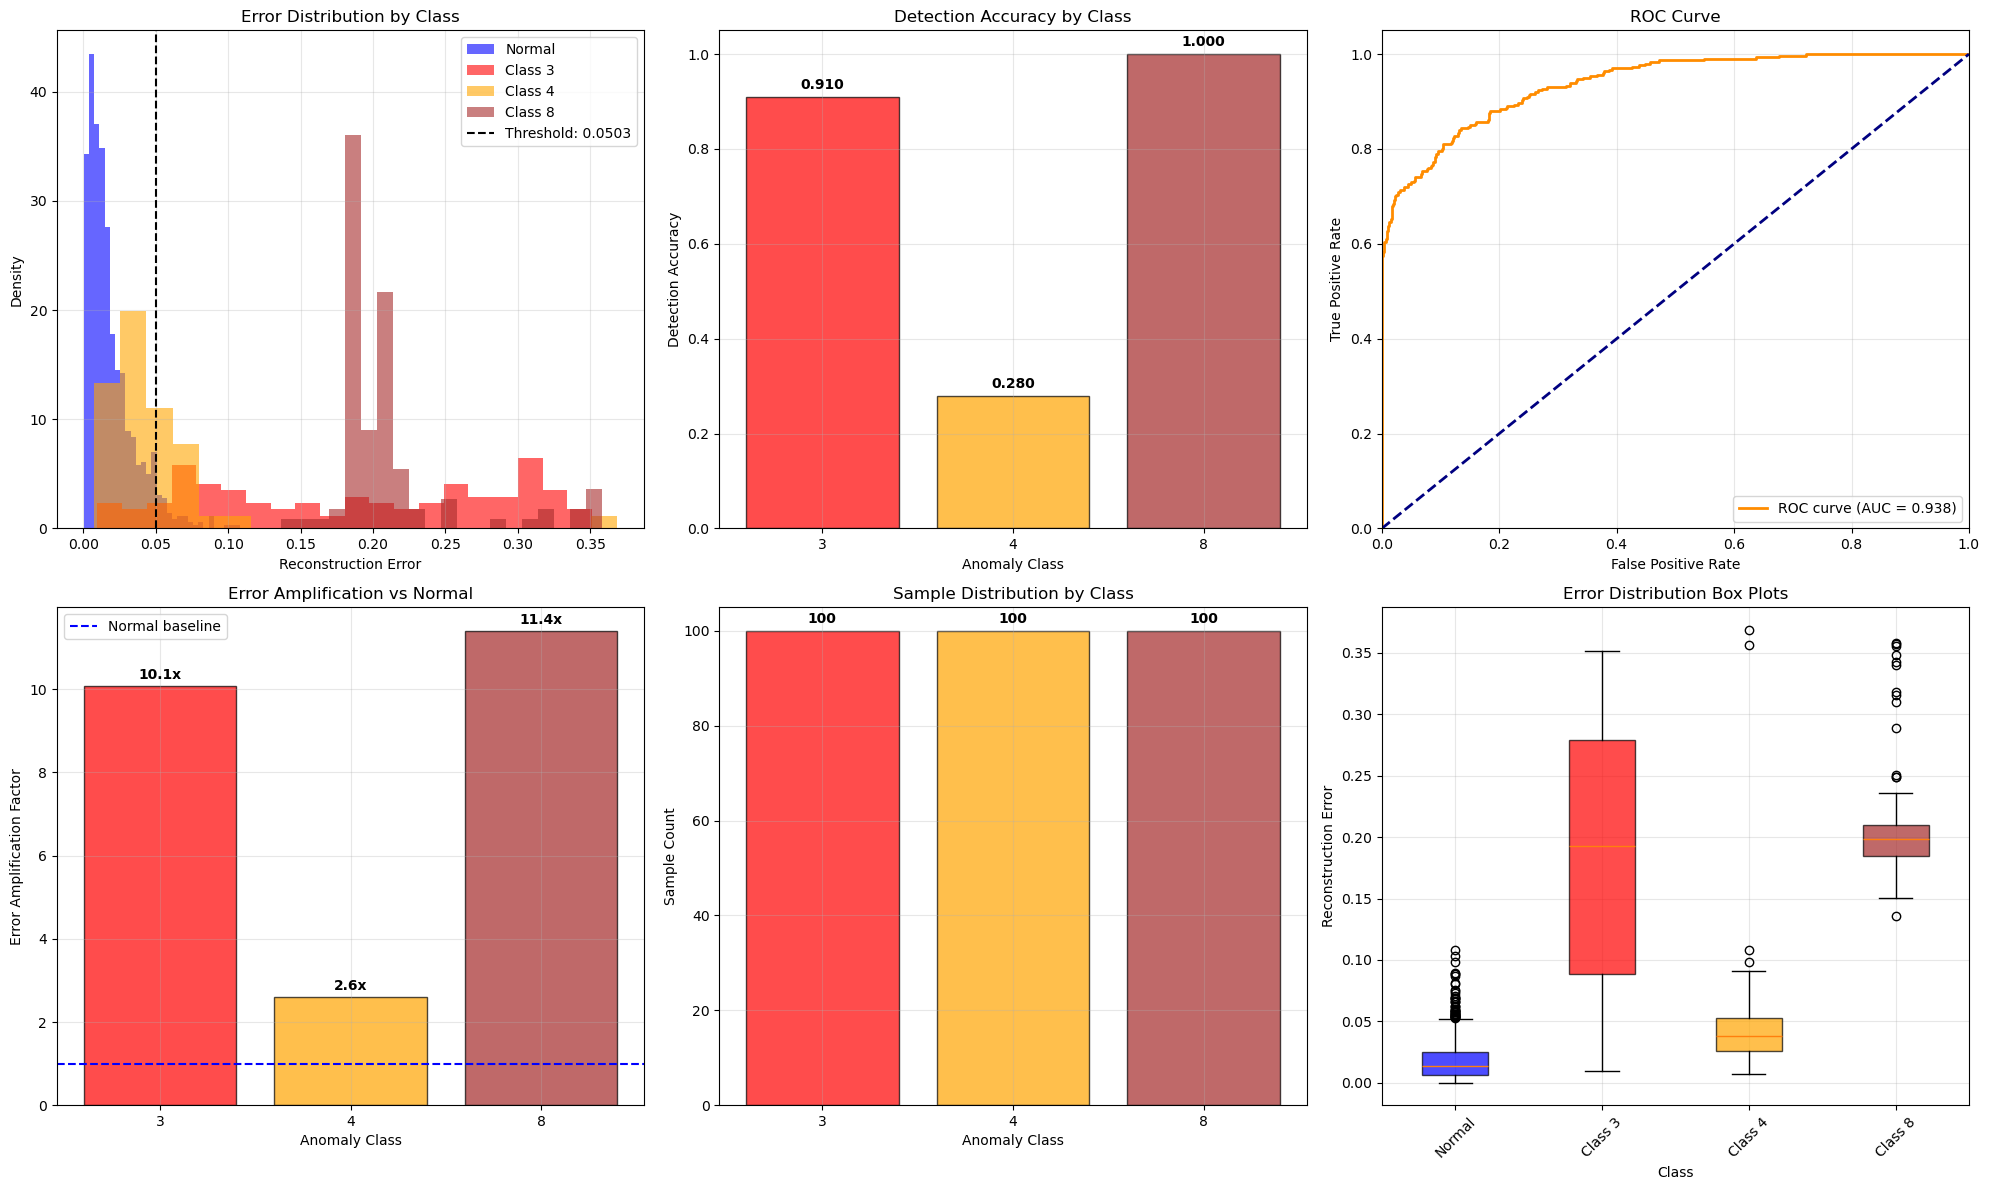


📊 Analysis Summary:
   • Overall ROC AUC: 0.938
   • Total normal samples: 1000
   • Total anomaly samples: 300
   • Anomaly classes analyzed: 3
   🎉 Excellent anomaly detection performance!


In [10]:
# Comprehensive Results Visualization
if detection_complete and "per_class_metrics" in globals() and per_class_metrics:
    print("📈 Comprehensive Results Visualization")
    print("=" * 40)

    # Import and use the visualization class
    from src.anomaly_detection import PerClassAnomalyVisualizer

    # Create visualizer and generate comprehensive analysis
    visualizer = PerClassAnomalyVisualizer()

    # Store indices for per-class metrics (needed for detailed visualization)
    for cls in per_class_metrics.keys():
        cls_indices = [
            i
            for i, anomaly_cls in enumerate(anomaly_classes)
            if str(
                int(anomaly_cls)
                if isinstance(anomaly_cls, (np.integer, int))
                else anomaly_cls
            )
            == cls
        ]
        per_class_metrics[cls]["indices"] = cls_indices

    # Create comprehensive visualization
    fig = visualizer.create_comprehensive_analysis(
        normal_errors, anomaly_errors, per_class_metrics, threshold
    )

    # Calculate and display summary statistics
    from sklearn.metrics import roc_curve, auc

    y_true = np.concatenate(
        [np.zeros(len(normal_errors)), np.ones(len(anomaly_errors))]
    )
    y_scores = np.concatenate([normal_errors, anomaly_errors])
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n📊 Analysis Summary:")
    print(f"   • Overall ROC AUC: {roc_auc:.3f}")
    print(f"   • Total normal samples: {len(normal_errors)}")
    print(f"   • Total anomaly samples: {len(anomaly_errors)}")
    print(f"   • Anomaly classes analyzed: {len(per_class_metrics)}")

    # Performance assessment
    if roc_auc > 0.8:
        print(f"   🎉 Excellent anomaly detection performance!")
    elif roc_auc > 0.7:
        print(f"   👍 Good anomaly detection performance")
    else:
        print(f"   ⚠️ Consider tuning model parameters for better performance")

else:
    print(
        "❌ Cannot generate visualizations - detection not completed or no per-class metrics"
    )
    print("Please run the previous cells to generate detection results")

## 🔍 Advanced Analysis: Latent Space Exploration

### What is the Latent Space?

The **latent space** is the compressed representation learned by the encoder:
- Original data: High-dimensional (many sensors × time steps)
- Latent space: Low-dimensional (e.g., 64 dimensions)
- Contains the "essence" of the input patterns

### Why Explore Latent Space?

**Understanding Model Behavior**: See how the model represents different data types
**Pattern Visualization**: Use t-SNE to visualize high-dimensional latent vectors in 2D
**Class Separation**: Check if different anomaly types cluster differently

### t-SNE (t-Distributed Stochastic Neighbor Embedding):
- Dimensionality reduction technique for visualization
- Preserves local structure while reducing to 2D
- Similar patterns appear close together in the plot

In [11]:
# Latent Space Extraction and Analysis Setup
if detection_complete and "per_class_metrics" in globals():
    print("🔍 Advanced Latent Space Analysis")
    print("=" * 35)

    try:
        # Import latent space analyzer
        from src.latent_analysis import LatentSpaceAnalyzer

        # Initialize analyzer
        latent_analyzer = LatentSpaceAnalyzer()

        # Extract latent representations
        normal_latent, anomaly_latent, encoder = (
            latent_analyzer.extract_latent_representations(
                autoencoder,
                normal_scaled,
                anomaly_scaled,
                max_normal_samples=800,
                max_anomaly_samples=400,
            )
        )

        latent_analysis_ready = True

    except Exception as e:
        print(f"❌ Error in latent space setup: {str(e)}")
        latent_analysis_ready = False

else:
    print("❌ Latent space analysis requires completed detection results")
    latent_analysis_ready = False

🔍 Advanced Latent Space Analysis
Extracting Latent Representations
Processing 800 normal and 300 anomaly samples...
✅ Latent extraction complete:
   • Normal latent shape: (800, 64)
   • Anomaly latent shape: (300, 64)
   • Latent dimension: 64
✅ Latent extraction complete:
   • Normal latent shape: (800, 64)
   • Anomaly latent shape: (300, 64)
   • Latent dimension: 64


In [12]:
# Compute Per-Class Latent Statistics
if latent_analysis_ready:
    # Compute per-class latent statistics
    class_latent_stats = latent_analyzer.compute_latent_statistics(
        per_class_metrics, anomaly_classes, max_samples=400
    )

    # Compute t-SNE embedding
    normal_tsne, anomaly_tsne, tsne_embedding = latent_analyzer.compute_tsne_embedding(
        perplexity=30, random_state=42
    )

    print(f"\n✅ Latent analysis preparation complete")
    print(f"   • Classes with latent statistics: {len(class_latent_stats)}")
    print(f"   • t-SNE embedding shape: {tsne_embedding.shape}")

else:
    print("❌ Cannot compute latent statistics - setup not completed")

Computing Per-Class Latent Statistics
Overall Statistics:
   • Normal latent mean magnitude: 1.979
   • Anomaly latent mean magnitude: 1.542
   • Mean separation distance: 0.648

Per-Class Statistics:
   • Class 3: separation = 0.576, samples = 100
   • Class 4: separation = 0.209, samples = 100
   • Class 8: separation = 1.366, samples = 100
Computing t-SNE Embedding
Running t-SNE with perplexity=30...


c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


✅ t-SNE embedding complete

✅ Latent analysis preparation complete
   • Classes with latent statistics: 3
   • t-SNE embedding shape: (1100, 2)


## 🎨 Latent Space Visualization and Insights

### What the Visualizations Show

**Latent Space PCA**: Principal component analysis of compressed representations
- Shows the main directions of variation in the latent space

**t-SNE Plot**: 2D visualization of latent clusters
- Each point represents one time series window
- Colors represent different anomaly classes
- Clustering patterns reveal model's internal organization

**Correlation Analysis**: Relationship between latent separation and detection accuracy
- Higher separation → easier detection
- Validates that the latent space encodes meaningful differences

📊 Creating Comprehensive Latent Space Visualization
Creating Comprehensive Latent Visualization


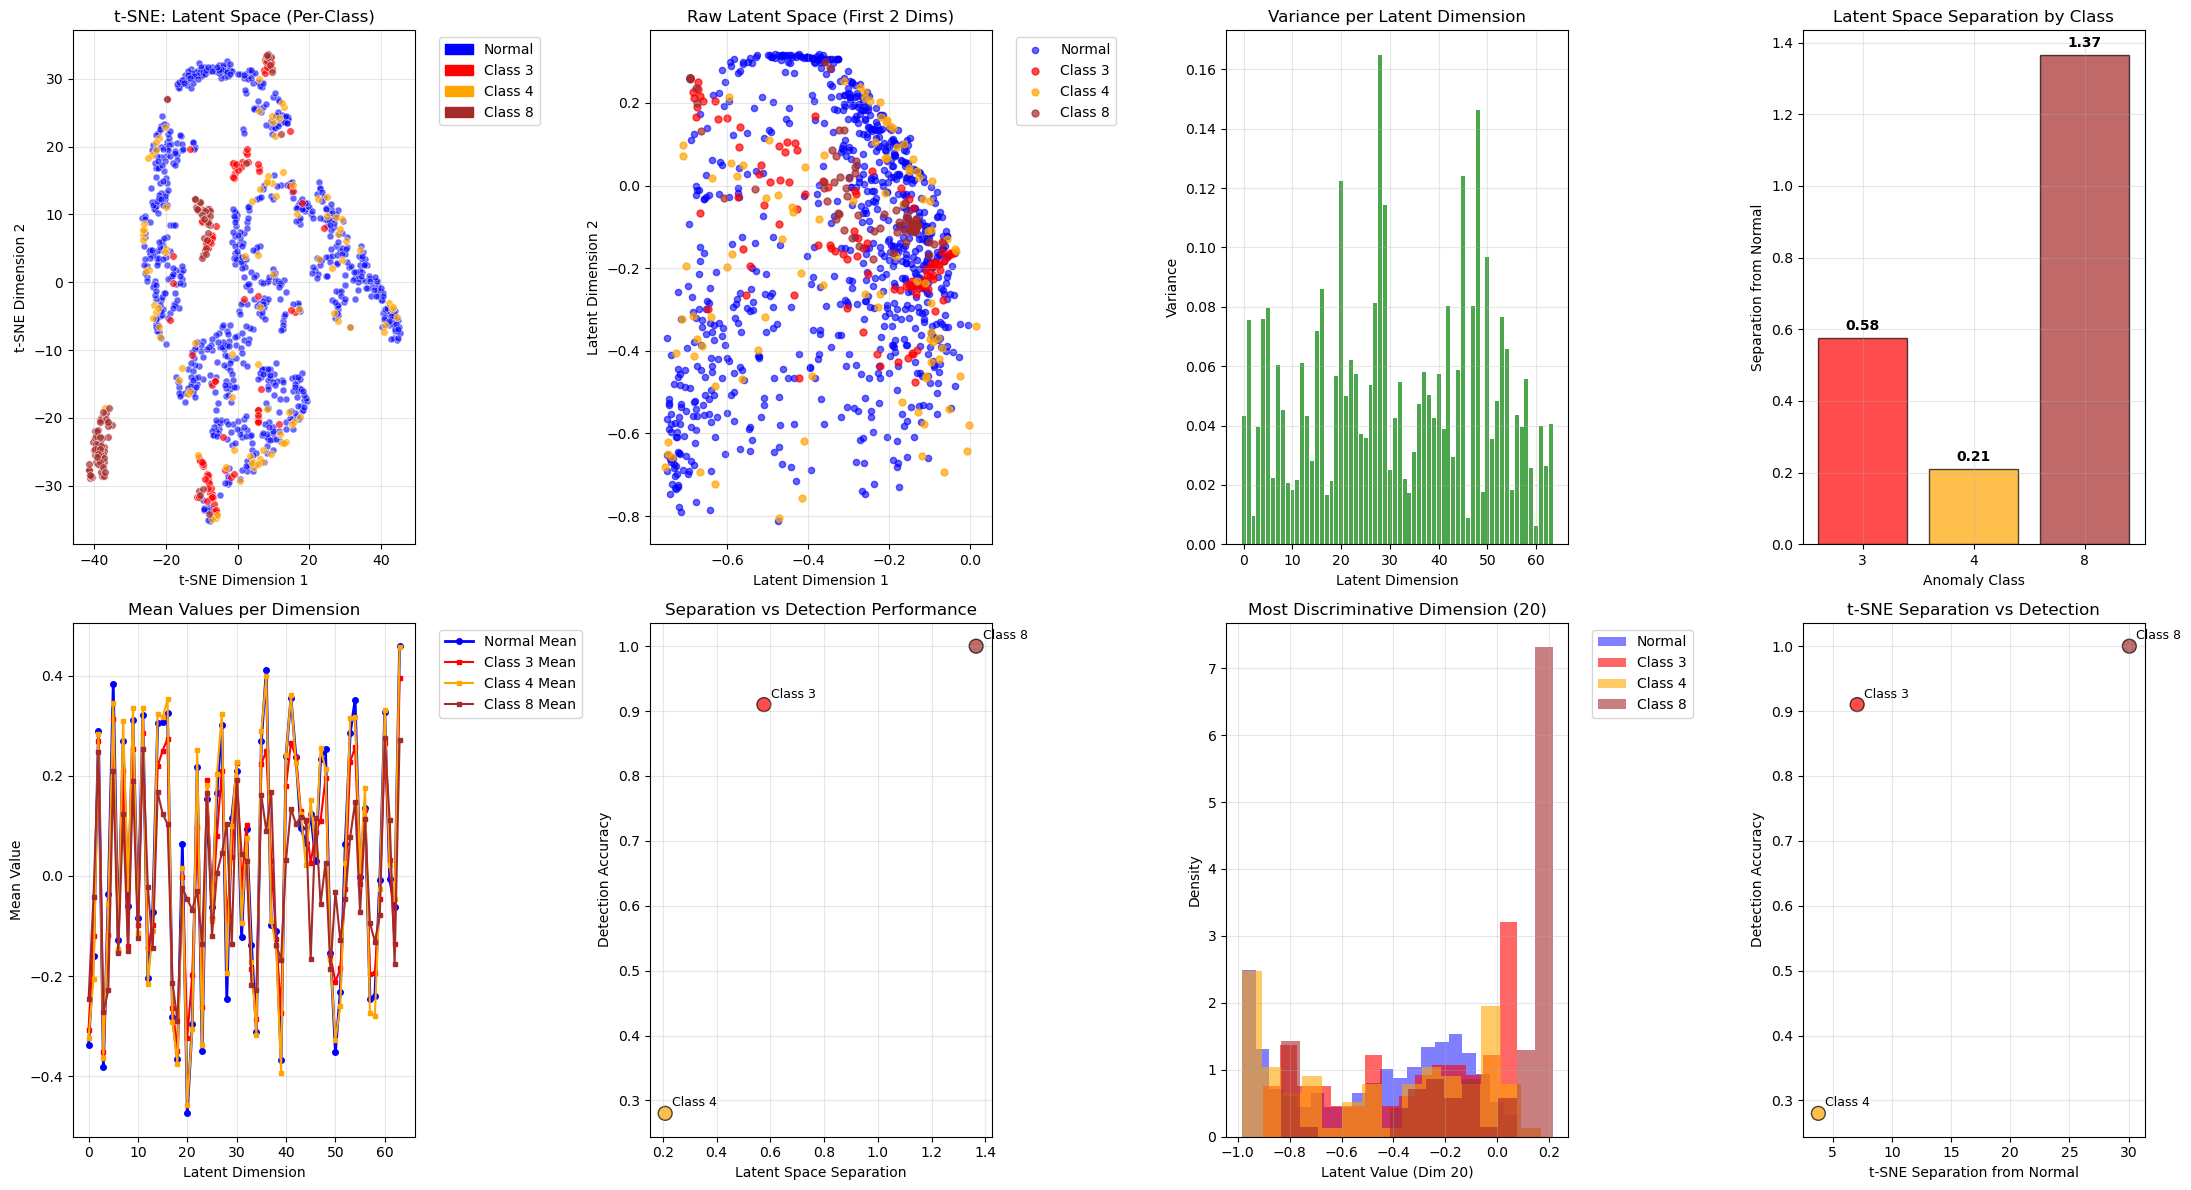


🔍 Latent Space Analysis Summary:
   • Latent dimension: 64
   • Normal samples analyzed: 800
   • Anomaly samples analyzed: 300
   • Classes with statistics: 3

📊 Correlation Analysis:
   • Latent separation vs Detection accuracy: r=0.816 (p=0.392)
   • Strong correlation detected between latent separation and detection performance

🎯 Key Insights:
   • Latent space visualization shows class clustering patterns
   • Each anomaly class has distinct latent space characteristics
   • t-SNE reveals 2D structure of high-dimensional latent space
   • Latent separation correlates with detection performance


In [13]:
# Comprehensive Latent Space Visualization
if latent_analysis_ready and "class_latent_stats" in locals():
    print("📊 Creating Comprehensive Latent Space Visualization")
    print("=" * 55)

    # Create comprehensive visualization
    fig = latent_analyzer.create_comprehensive_latent_visualization(
        per_class_metrics,
        class_latent_stats,
        normal_tsne,
        anomaly_tsne,
        anomaly_classes,
    )

    # Print detailed analysis summary
    print(f"\n🔍 Latent Space Analysis Summary:")
    print(f"   • Latent dimension: {normal_latent.shape[1]}")
    print(f"   • Normal samples analyzed: {len(normal_latent)}")
    print(f"   • Anomaly samples analyzed: {len(anomaly_latent)}")
    print(f"   • Classes with statistics: {len(class_latent_stats)}")

    # Correlation analysis if enough classes
    if len(class_latent_stats) > 2:
        try:
            from scipy.stats import pearsonr

            # Get separations and accuracies for correlation
            classes = sorted(class_latent_stats.keys())
            latent_seps = [class_latent_stats[cls]["separation"] for cls in classes]
            accuracies = [per_class_metrics[cls]["accuracy"] for cls in classes]

            corr_coef, p_value = pearsonr(latent_seps, accuracies)

            print(f"\n📊 Correlation Analysis:")
            print(
                f"   • Latent separation vs Detection accuracy: r={corr_coef:.3f} (p={p_value:.3f})"
            )

            if abs(corr_coef) > 0.5:
                print(
                    f"   • Strong correlation detected between latent separation and detection performance"
                )
            else:
                print(
                    f"   • Moderate/weak correlation between latent separation and detection performance"
                )

        except ImportError:
            print(f"\n📊 Correlation analysis requires scipy (not available)")

    print(f"\n🎯 Key Insights:")
    print(f"   • Latent space visualization shows class clustering patterns")
    print(f"   • Each anomaly class has distinct latent space characteristics")
    print(f"   • t-SNE reveals 2D structure of high-dimensional latent space")
    print(f"   • Latent separation correlates with detection performance")

else:
    print("❌ Cannot create comprehensive visualization - latent analysis not ready")

## 🎛️ Interactive Threshold Analysis

### The Threshold Decision Challenge

Choosing the right threshold is crucial for practical anomaly detection:

**Conservative Threshold (High)**: 
- ✅ Fewer false alarms
- ❌ May miss subtle anomalies

**Aggressive Threshold (Low)**:
- ✅ Catches more anomalies  
- ❌ More false alarms

### Threshold Methods Compared:
- **Statistical**: Based on normal data distribution (μ + kσ)
- **Percentile**: Based on ranking of normal errors
- **ROC-Optimized**: Maximizes true positive rate vs false positive rate

### Business Impact:
In oil well monitoring, false alarms cost money, but missing real problems can be catastrophic!

🎛️ Interactive Threshold Analysis
📊 Threshold Comparison Analysis:
Method               Threshold    Normal FP    Anomaly TP   Balance   
----------------------------------------------------------------------
Statistical (μ + 2σ) 0.051206     0.047        0.727        0.680     
Statistical (μ + 3σ) 0.067591     0.017        0.667        0.650     
Percentile 90%       0.041755     0.100        0.797        0.697     
Percentile 95%       0.050286     0.050        0.730        0.680     
Percentile 99%       0.074549     0.010        0.633        0.623     


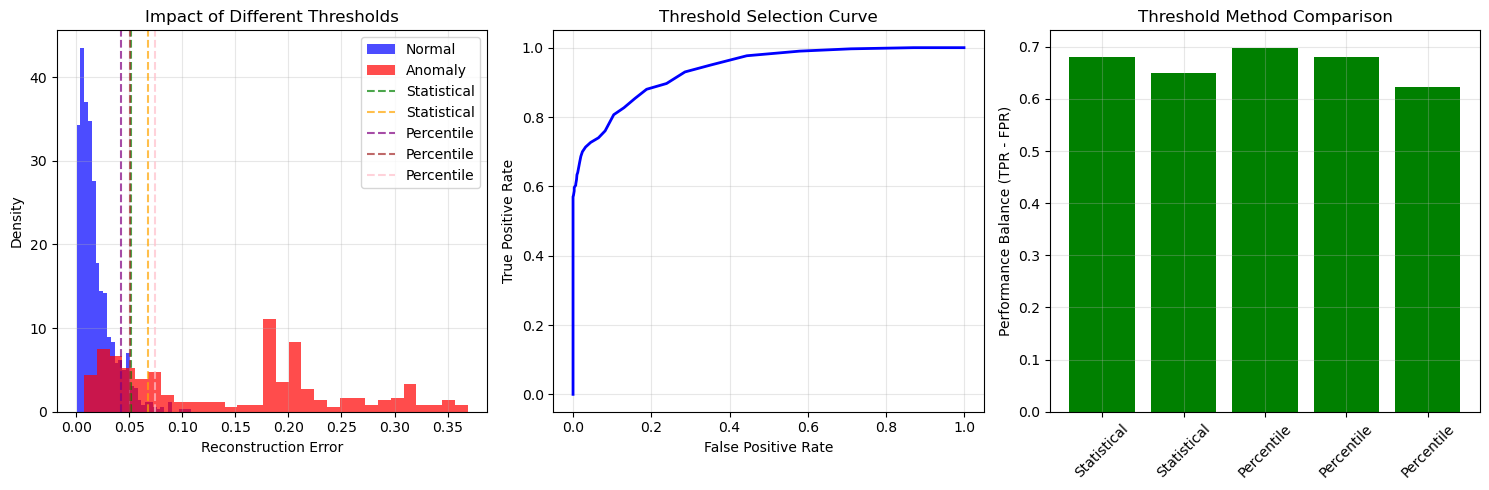


🏆 Best performing threshold method: Percentile 90%
   • Threshold value: 0.041755
   • This demonstrates how threshold selection critically impacts performance


In [14]:
# Interactive Threshold Analysis
if "detector" in globals() and detector.normal_errors is not None:
    print("🎛️ Interactive Threshold Analysis")
    print("=" * 40)

    # Test different threshold methods and percentiles
    threshold_methods = {
        "Statistical (μ + 2σ)": np.mean(detector.normal_errors)
        + 2 * np.std(detector.normal_errors),
        "Statistical (μ + 3σ)": np.mean(detector.normal_errors)
        + 3 * np.std(detector.normal_errors),
        "Percentile 90%": np.percentile(detector.normal_errors, 90),
        "Percentile 95%": np.percentile(detector.normal_errors, 95),
        "Percentile 99%": np.percentile(detector.normal_errors, 99),
    }

    print(f"📊 Threshold Comparison Analysis:")
    print(
        f"{'Method':<20} {'Threshold':<12} {'Normal FP':<12} {'Anomaly TP':<12} {'Balance':<10}"
    )
    print("-" * 70)

    for method_name, threshold_val in threshold_methods.items():
        # Calculate performance for this threshold
        normal_fp = np.sum(detector.normal_errors > threshold_val) / len(
            detector.normal_errors
        )
        anomaly_tp = np.sum(detector.anomaly_errors > threshold_val) / len(
            detector.anomaly_errors
        )
        balance = anomaly_tp - normal_fp  # Higher is better

        print(
            f"{method_name:<20} {threshold_val:<12.6f} {normal_fp:<12.3f} {anomaly_tp:<12.3f} {balance:<10.3f}"
        )

    # Visualization of threshold impact
    plt.figure(figsize=(15, 5))

    # Plot 1: Error distributions with different thresholds
    plt.subplot(1, 3, 1)
    plt.hist(
        detector.normal_errors,
        bins=30,
        alpha=0.7,
        label="Normal",
        color="blue",
        density=True,
    )
    plt.hist(
        detector.anomaly_errors,
        bins=30,
        alpha=0.7,
        label="Anomaly",
        color="red",
        density=True,
    )

    colors = ["green", "orange", "purple", "brown", "pink"]
    for i, (method, thresh) in enumerate(list(threshold_methods.items())[:5]):
        plt.axvline(
            thresh,
            color=colors[i],
            linestyle="--",
            alpha=0.7,
            label=f"{method.split()[0]}",
        )

    plt.xlabel("Reconstruction Error")
    plt.ylabel("Density")
    plt.title("Impact of Different Thresholds")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: ROC-like curve for threshold selection
    plt.subplot(1, 3, 2)
    thresholds = np.linspace(
        min(detector.normal_errors), max(detector.anomaly_errors), 100
    )
    tpr_scores = []
    fpr_scores = []

    for thresh in thresholds:
        tpr = np.sum(detector.anomaly_errors > thresh) / len(detector.anomaly_errors)
        fpr = np.sum(detector.normal_errors > thresh) / len(detector.normal_errors)
        tpr_scores.append(tpr)
        fpr_scores.append(fpr)

    plt.plot(fpr_scores, tpr_scores, "b-", linewidth=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Threshold Selection Curve")
    plt.grid(True, alpha=0.3)

    # Plot 3: Performance balance
    plt.subplot(1, 3, 3)
    methods = list(threshold_methods.keys())
    balances = []
    for method in methods:
        thresh = threshold_methods[method]
        tpr = np.sum(detector.anomaly_errors > thresh) / len(detector.anomaly_errors)
        fpr = np.sum(detector.normal_errors > thresh) / len(detector.normal_errors)
        balances.append(tpr - fpr)

    plt.bar(
        range(len(methods)),
        balances,
        color=["green" if b > 0 else "red" for b in balances],
    )
    plt.xticks(range(len(methods)), [m.split()[0] for m in methods], rotation=45)
    plt.ylabel("Performance Balance (TPR - FPR)")
    plt.title("Threshold Method Comparison")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Find best performing threshold
    best_method = max(
        threshold_methods.items(),
        key=lambda x: np.sum(detector.anomaly_errors > x[1])
        / len(detector.anomaly_errors)
        - np.sum(detector.normal_errors > x[1]) / len(detector.normal_errors),
    )

    print(f"\n🏆 Best performing threshold method: {best_method[0]}")
    print(f"   • Threshold value: {best_method[1]:.6f}")
    print(
        f"   • This demonstrates how threshold selection critically impacts performance"
    )

else:
    print("❌ Interactive threshold analysis requires completed anomaly detection")

## 🏗️ Architecture Impact and Model Understanding

### Model Architecture Trade-offs

**Latent Dimension**: The compression bottleneck
- Small (e.g., 4): Aggressive compression, may lose details
- Large (e.g., 64): Retains more information, less compression

**LSTM Units**: Model capacity
- Few units: Simple patterns, fast training
- Many units: Complex patterns, longer training

### Reconstruction Quality

The visualization shows how well the autoencoder reconstructs normal data:
- **Good reconstruction**: Low error, preserves important patterns
- **Poor reconstruction**: High error, loses critical information

This directly impacts anomaly detection performance!


📚 Architecture Comparison (Educational Purpose):
Architecture Latent Dim   LSTM Units   Description               Trade-offs
-------------------------------------------------------------------------------------
Minimal      4            16           Very compressed representation ⚡ Fast, may lose details
Current      16           64           Balanced compression      ✅ Good balance (current model)
Detailed     32           128          High-capacity model       🎯 Detailed, slower training

🧠 Current Model Analysis:
   • Total parameters: 175,043
   • Approximate memory: 0.7 MB
   • Latent compression ratio: 56.2:1
   • Information bottleneck: 64 dimensions capture 3 sensor patterns

🔍 Reconstruction Quality Demonstration:


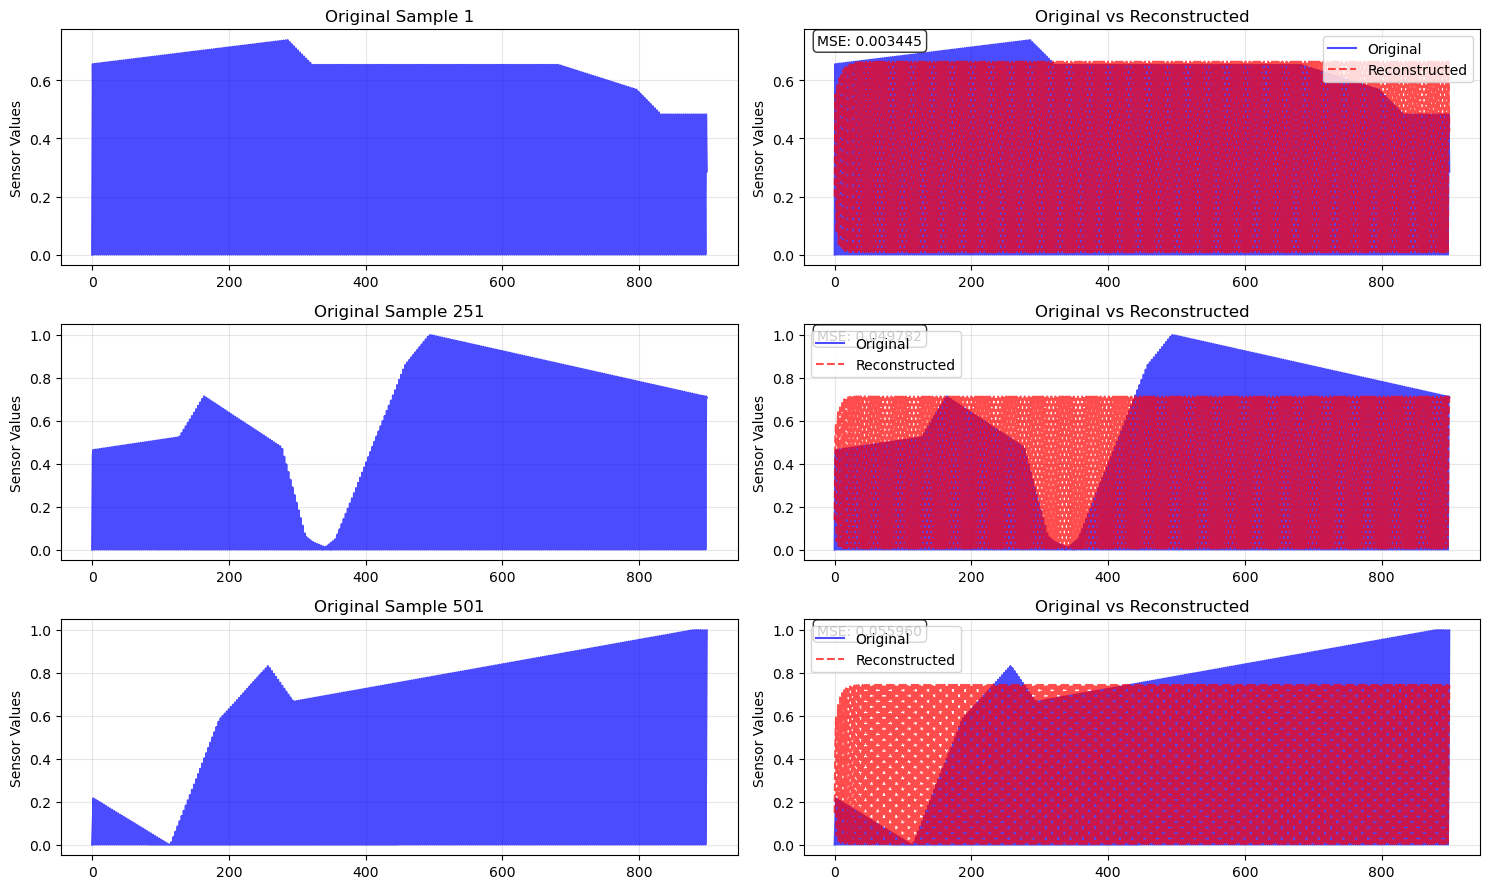

In [15]:
# Architecture Impact
if model_ready and "data_info" in globals():
    # Quick architecture comparison
    architectures = [
        {
            "name": "Minimal",
            "latent_dim": 4,
            "lstm_units": 16,
            "description": "Very compressed representation",
        },
        {
            "name": "Current",
            "latent_dim": 16,
            "lstm_units": 64,
            "description": "Balanced compression",
        },
        {
            "name": "Detailed",
            "latent_dim": 32,
            "lstm_units": 128,
            "description": "High-capacity model",
        },
    ]

    print(f"\n📚 Architecture Comparison (Educational Purpose):")
    print(
        f"{'Architecture':<12} {'Latent Dim':<12} {'LSTM Units':<12} {'Description':<25} {'Trade-offs'}"
    )
    print("-" * 85)

    for arch in architectures:
        if arch["name"] == "Current":
            trade_offs = "✅ Good balance (current model)"
        elif arch["name"] == "Minimal":
            trade_offs = "⚡ Fast, may lose details"
        else:
            trade_offs = "🎯 Detailed, slower training"

        print(
            f"{arch['name']:<12} {arch['latent_dim']:<12} {arch['lstm_units']:<12} {arch['description']:<25} {trade_offs}"
        )

    # Model complexity analysis
    total_params = autoencoder.model.count_params()
    memory_usage = total_params * 4 / (1024 * 1024)  # Approximate MB for float32

    print(f"\n🧠 Current Model Analysis:")
    print(f"   • Total parameters: {total_params:,}")
    print(f"   • Approximate memory: {memory_usage:.1f} MB")
    print(
        f"   • Latent compression ratio: {data_info['n_features'] * data_info['time_steps'] / 16:.1f}:1"
    )
    print(
        f"   • Information bottleneck: {64} dimensions capture {data_info['n_features']} sensor patterns"
    )

    # Demonstrate reconstruction quality on different samples
    print(f"\n🔍 Reconstruction Quality Demonstration:")

    # Sample a few examples for demonstration
    sample_indices = [0, len(normal_scaled) // 4, len(normal_scaled) // 2]

    fig, axes = plt.subplots(
        len(sample_indices), 2, figsize=(15, 3 * len(sample_indices))
    )
    if len(sample_indices) == 1:
        axes = [axes]

    for i, idx in enumerate(sample_indices):
        # Original
        original = normal_scaled[idx]
        reconstructed = autoencoder.model.predict(
            original.reshape(1, *original.shape), verbose=0
        )[0]

        # Plot original
        axes[i][0].plot(original.flatten(), "b-", alpha=0.7, label="Original")
        axes[i][0].set_title(f"Original Sample {idx+1}")
        axes[i][0].set_ylabel("Sensor Values")
        axes[i][0].grid(True, alpha=0.3)

        # Plot reconstruction
        axes[i][1].plot(original.flatten(), "b-", alpha=0.7, label="Original")
        axes[i][1].plot(
            reconstructed.flatten(), "r--", alpha=0.7, label="Reconstructed"
        )
        axes[i][1].set_title(f"Original vs Reconstructed")
        axes[i][1].set_ylabel("Sensor Values")
        axes[i][1].legend()
        axes[i][1].grid(True, alpha=0.3)

        # Calculate reconstruction error
        error = np.mean((original - reconstructed) ** 2)
        axes[i][1].text(
            0.02,
            0.98,
            f"MSE: {error:.6f}",
            transform=axes[i][1].transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

    plt.tight_layout()
    plt.show()

else:
    print("❌ Architecture analysis requires completed model training")